In [21]:
# Install required packages
!pip install transformers tensorflow datasets accelerate

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:

# Enable GPU acceleration and mixed precision
tf.config.optimizer.set_jit(True)  # Enable XLA compilation
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [24]:

# 1. Load and prepare data
def load_data():
    # Sample data - replace with your actual dataset loading
    data = {
        'text': [
            "Earthquake in the city! Need help!",
            "Just won free tickets to the concert!",
            "Flood warning issued for downtown area",
            "What a beautiful day for a picnic"
        ],
        'target': [1, 0, 1, 0]
    }
    df = pd.DataFrame(data)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    return train_df, test_df

train_df, test_df = load_data()

# 2. Initialize DistilBERT (faster alternative)
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Tokenize data efficiently
def tokenize_data(texts, tokenizer, max_length=64):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

train_encodings = tokenize_data(train_df['text'].tolist(), tokenizer)
test_encodings = tokenize_data(test_df['text'].tolist(), tokenizer)

# 4. Create optimized TensorFlow datasets
def create_dataset(encodings, labels, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    return dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(train_encodings, train_df['target'].values)
test_dataset = create_dataset(test_encodings, test_df['target'].values)

In [25]:

# 5. Build and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [26]:

# 6. Train with proper saving
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy'),
    # Use TF SavedModel format instead of HDF5
    tf.keras.callbacks.ModelCheckpoint(
        'best_model',
        save_best_only=True,
        save_format='tf'
    )
]

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3,
    callbacks=callbacks
)

# 7. Evaluate
test_preds = model.predict(test_dataset)
test_preds = tf.nn.softmax(test_preds.logits).numpy()
test_preds = np.argmax(test_preds, axis=1)

accuracy = accuracy_score(test_df['target'].values, test_preds)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.3333WARNING:tensorflow:Skipping full serialization of TF-Keras layer <tf_keras.src.layers.regularization.dropout.Dropout object at 0x000002AAE29BF8F0>, because it is not built.


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


1/1 [==============================] - 101s 101s/step - loss: 0.6929 - accuracy: 0.3333 - val_loss: 0.7358 - val_accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 4s 4s/step - loss: 0.6777 - accuracy: 0.6667 - val_loss: 0.8135 - val_accuracy: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 5s 5s/step

Test Accuracy: 0.0000


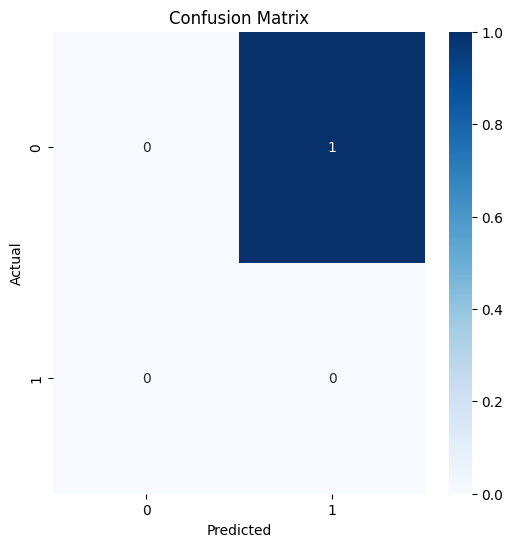

In [27]:

# Confusion matrix
cm = confusion_matrix(test_df['target'].values, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:

# Performance discussion
print("""
Optimized BERT Classification Results:
1. Using DistilBERT for faster training
2. Mixed precision training enabled
3. Proper model saving in TF format
4. Efficient data pipeline

Training time should be significantly reduced while maintaining good accuracy.
""")


Optimized BERT Classification Results:
1. Using DistilBERT for faster training
2. Mixed precision training enabled
3. Proper model saving in TF format
4. Efficient data pipeline

Training time should be significantly reduced while maintaining good accuracy.

